In [1]:
import pandas as pd
import numpy as np

In [2]:

data = pd.read_csv("Processed_S&P.csv", parse_dates=[0])
data = data[["Date", "Close", "Volume", \
             "mom", "mom1", "mom2", "mom3",\
            "ROC_5","ROC_10","ROC_15","ROC_20",\
            "EMA_10","EMA_20","EMA_50"]]

# drop NA
data = data.dropna(axis = 0)
print("Start date: ", data["Date"].min())
print("End date: ", data["Date"].max())

data = data.sort_values(by = "Date")

data.head()

Start date:  2010-03-15 00:00:00
End date:  2017-11-15 00:00:00


,Date,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,ROC_20,EMA_10,EMA_20,EMA_50
49,2010-03-15,1150.510010,-0.155038,0.000452,-0.000217,0.004042,0.004525,1.054898,3.119095,3.835705,6.973436,1137.793700,1125.859965,1112.939394
50,2010-03-16,1159.459961,0.049389,0.007779,0.000452,-0.000217,0.004042,1.666887,3.679651,5.925451,5.899327,1141.733020,1129.059965,1114.763730
51,2010-03-17,1166.209961,0.135803,0.005822,0.007779,0.000452,-0.000217,1.798167,4.238501,5.516446,6.066334,1146.183373,1132.598059,1116.781230
52,2010-03-18,1165.829956,-0.146819,-0.000326,0.005822,0.007779,0.000452,1.355366,3.816664,5.702034,5.338148,1149.755479,1135.763002,1118.704709
53,2010-03-19,1159.900024,0.230936,-0.005086,-0.000326,0.005822,0.007779,0.861750,1.861779,5.016798,4.573688,1151.599942,1138.061766,1120.320212


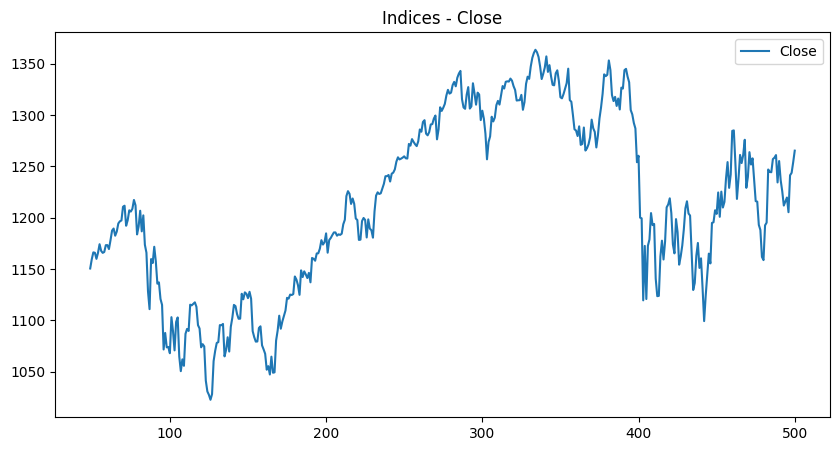

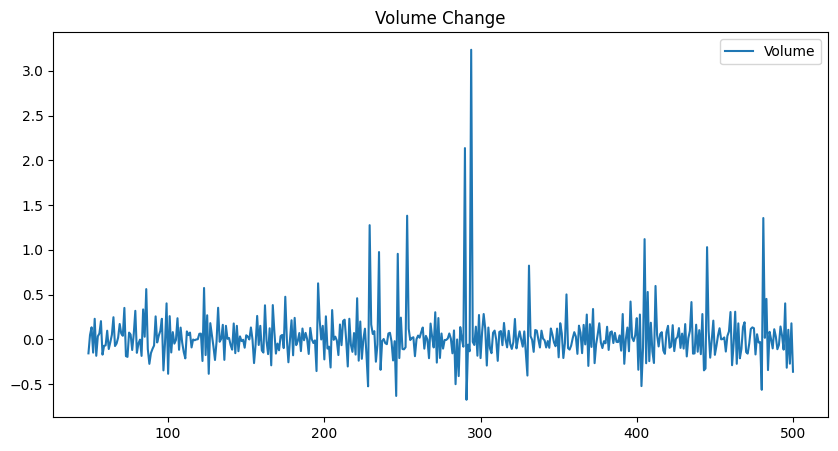

In [3]:
from matplotlib import pyplot as plt
data.loc[0:500]["Close"].plot(kind="line", figsize=(10,5), title = "Indices - Close")
plt.legend()
plt.show()

data.loc[0:500]["Volume"].plot(kind="line", figsize=(10,5), title = "Volume Change")
plt.legend()
plt.show()

* Preprocess the data to a format a neural network can ingest. Write a function to generate train, evaluation, and test datasets as follows:

    - Use all observations after the `cut_off` date for testing purpose and the remaining for training (including validation).  
    
    - Transform the dataset by `z-normalization`. Since the features are in different scales, it is necessary to normalize them. A typical technique is z-normalization, $x^{'} = (x - \mu)/\sigma$ where $\mu$ is the mean and $\sigma$ is the standard deviation. However, don't rely on batch normalization technique here, since a random batch cannot preserve the trending of the time series. Instead, for this step, do the following:
        - Fit a scaler using `only the training subset` (i.e calculate $\mu$ and $\sigma$). Your testing subset should `never` be exposed to the scaler or your training program. You can use package <a href ="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html"> `sklearn.preprocessing.StandardScaler`</a> for this step.
        - Transform the entire dataset using the fitted scaler. If you want to transform the data back to the orginal, you can call the scaler's `inverse_transform` function. 

    - Slice the transformed dataset in every `lookback` days. For example, let ($x_i, y_i$) denote the $i$th sample. $x_i$ `= X[i : (i + lookback)]` and $y_i$ `= Y[ i + lookback]`, where X is the transformed values of `feature_cols` which are the columns used for features, and Y is the transformed `Close` column. If you predict the S&P indexes in the next `lookforward` day, your target should be a sequence of S&P indices in the next `lookfoward` days. You can use any column as a feature, or engineer new features. 
    
    - Split the transformed dataset by the `cut_off` to get training/test sets. Then for the training set, hold out 20% for `validation` 
    
    - Formulate a dataset class and initiate train/evaluation/test dataset objects
    
    - Return transformed train/evaluation/test dataset objects and the normalization scaler.

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


import torch.nn as nn
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import glob
from torch.utils.data import DataLoader,Dataset
from PIL import Image

from torch.utils.data import DataLoader, random_split, Dataset
from torchinfo import summary
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [6]:
from sklearn.preprocessing import StandardScaler

class TimeSeries_Dataset(Dataset):
    
    def __init__(self, X,Y):
        self.X = torch.tensor(X, dtype = torch.float)
        self.Y = torch.tensor(Y, dtype = torch.float)
        
    def __getitem__(self, index):
        
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.X)  

def generate_Datasets(data, feature_cols, target_col, cut_off, lookback=5):
        
    X = []  # input
    Y = []  # target
    
    cut_off_index = data[data.Date < cut_off].index[-1]
    #print(cut_off_index)
    train_data = data[data.Date < cut_off]

    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    x_scaler.fit(train_data[feature_cols].values)
    y_scaler.fit(train_data[target_col].values[:,None])

    X_normalized = x_scaler.transform(data[feature_cols].values)
    Y_normalized = y_scaler.transform(data[target_col].values[:,None])
    
    for idx in range(0, len(data)):

        if len(data)<=idx+lookback+1:
            break

        x = X_normalized[idx:(idx+lookback)]
        y = Y_normalized[idx+lookback]

        X.append(x)
        Y.append(y)

    X = np.array(X)
    Y = np.array(Y)

    X_train = X[0:(cut_off_index-lookback)]
    Y_train = Y[0:(cut_off_index-lookback)]

    X_train, X_eval, Y_train, Y_eval = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 123)

    X_test = X[(cut_off_index-lookback):]
    Y_test = Y[(cut_off_index-lookback):]
        
    train_dataset = TimeSeries_Dataset(X_train, Y_train)
    eval_dataset = TimeSeries_Dataset(X_eval, Y_eval)
    test_dataset = TimeSeries_Dataset(X_test, Y_test)
    
    return train_dataset, eval_dataset, test_dataset, x_scaler, y_scaler

In [9]:
np.set_printoptions(precision = 3)

feature_cols = ["Close","Volume", "mom", "mom1", "mom2", "mom3",\
            "ROC_5","ROC_10","ROC_15","ROC_20",\
            "EMA_10","EMA_20","EMA_50"]  # feel free to add your own features, e.g. volume, day, week, etc.
target_col = "Close"
lookback = 5
cut_off = '2017-01-01'
data = data.sort_values(by = 'Date').reset_index(drop = True)

train_dataset, eval_data, test_dataset, x_scaler, y_scale = generate_Datasets(data, feature_cols, target_col, cut_off, lookback=5) 

In [10]:
x, y = test_dataset.__getitem__(0)
print(x,y)
print(x.size(),y.size())
print(f"moving avg: {x[:,0].mean()}")

tensor([[ 1.6435, -0.0475, -0.2351, -0.2961,  0.3267,  0.1560, -0.1291,  0.0815,
          0.7840,  0.4597,  1.6428,  1.6057,  1.5404],
        [ 1.6512, -1.4530,  0.0833, -0.2353, -0.2963,  0.3259,  0.0165, -0.0936,
          0.8114,  0.3845,  1.6466,  1.6124,  1.5470],
        [ 1.6652, -0.1624,  0.1852,  0.0830, -0.2356, -0.2972,  0.0297,  0.0332,
          0.6975,  0.5976,  1.6522,  1.6197,  1.5539],
        [ 1.6132,  0.8506, -0.8988,  0.1849,  0.0828, -0.2364, -0.5508, -0.5220,
          0.3225,  0.3221,  1.6474,  1.6215,  1.5585],
        [ 1.6114, -0.1938, -0.0746, -0.8991,  0.1847,  0.0820, -0.4467, -0.2305,
         -0.0972,  0.3888,  1.6430,  1.6228,  1.5628]]) tensor([1.5829])
torch.Size([5, 13]) torch.Size([1])
moving avg: 1.6369044780731201


Create a function `evaluate_naive_method` to estalish a baseline. Your objective is to try to beat the baseline by a RNN model. A simple baselien can be created as follows:
* Let's use the mean value of stock indices in the past `lookback` days as the baseline, i.e. the prediction is the mean of the indices in the last `lookback` days. For example, the prediction from `X[0]` in the above example is `X[0,:,0].mean(axis = 0)`, which is  `1.64`.
* Calculate the `mean absolute error (MAE)` and `accuracy` on the `testing data` as the baseline, i.e. the error of the previous example is `abs(Y[0] - X[0,:,0].mean(axis = 0))`
* Feel free to use more advanced method, i.e. ARIMA, to creat a baseline. 

In [11]:
# Define a function to calculate a baseline on the testing data

def evaluate_naive_method(test_X, test_Y):
    mae = []
    preds = test_X.mean(dim = 1)
    error = (preds - test_Y[:,0])
    mae = error.abs().mean(axis = 0)
    mse = error.square().mean(axis = 0)
      
    return mae, mse

periods_end_before = ['2017-01-01','2017-02-01','2017-03-01',
              '2017-04-01','2017-05-01',
              '2017-06-01','2017-07-01',
              '2017-08-01','2017-09-01',
               '2017-10-01','2017-11-01',
               '2017-12-01']
results = []
for i,d in enumerate(periods_end_before[1:]):
    cutoff = periods_end_before[i]
    data1 = data[data.Date<d]
    
    train_dataset, eval_data, test_dataset, x_scaler, y_scale = generate_Datasets(data1, feature_cols, target_col, cutoff, lookback=5) 
    
    mae, mse = evaluate_naive_method(test_dataset.X[:,:,0], test_dataset.Y)
    results.append([cutoff, d, mae, mse])
    
    print("period {0} - {1}: mae: {2:.4f}, mse: {3:.4f}".format(cutoff, d, mae, mse))

results = pd.DataFrame(results, columns =["start","end","mae","mse"])
results

results[["mae","mse"]].mean(axis = 0)

period 2017-01-01 - 2017-02-01: mae: 0.0260, mse: 0.0012
period 2017-02-01 - 2017-03-01: mae: 0.0405, mse: 0.0021
period 2017-03-01 - 2017-04-01: mae: 0.0325, mse: 0.0016
period 2017-04-01 - 2017-05-01: mae: 0.0283, mse: 0.0016
period 2017-05-01 - 2017-06-01: mae: 0.0278, mse: 0.0015
period 2017-06-01 - 2017-07-01: mae: 0.0182, mse: 0.0006
period 2017-07-01 - 2017-08-01: mae: 0.0249, mse: 0.0010
period 2017-08-01 - 2017-09-01: mae: 0.0247, mse: 0.0013
period 2017-09-01 - 2017-10-01: mae: 0.0269, mse: 0.0012
period 2017-10-01 - 2017-11-01: mae: 0.0251, mse: 0.0009
period 2017-11-01 - 2017-12-01: mae: 0.0187, mse: 0.0004


mae    0.026686
mse    0.001216
dtype: float64

In [12]:
class SP_Model(nn.Module):
    
    def __init__(self, feature_dim, hidden_dim, lstm_layers = 1 ):
        
        super(SP_Model, self).__init__()

        # Defining some parameters
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.lstm_layers = lstm_layers


        # RNN Layer
        self.bn = nn.BatchNorm1d(num_features = self.feature_dim)
        
        self.bilstm = nn.LSTM(input_size = self.feature_dim, hidden_size = self.hidden_dim, \
                            bidirectional = True,\
                            num_layers = self.lstm_layers, batch_first=True)
        
        #self.lstm = nn.LSTM(input_size = self.hidden_dim*2, hidden_size = self.hidden_dim*2, \
        #                    bidirectional = False, batch_first=True)
        
        self.fc = nn.Linear(self.hidden_dim*2 + self.feature_dim, 1)
        
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        
        # get the mean
        x_mean = x.mean(dim=1, keepdims = True)
        
        # remove mean from x so that deviation from mean can be considered uniform
        x_wo_mean = x- x_mean
        
        # batch normalize deviation
        x1 = torch.swapaxes(x_wo_mean, 1, 2)  # Batch Normalization on the feature dimension (Channel)
        x1 = self.bn(x1)
        x1 = torch.swapaxes(x1, 1, 2) # switch back
        
        # process deviation by LSTM
        out, (h, c) = self.bilstm(x1)
    
        # only use the last output
        out = out[:, -1, :]
        out = self.dropout(out)
        
        # concatenate mean and processed deviation
        out = torch.cat([x_mean.squeeze(),  out], dim = -1)
        
        out = self.fc(out)
        
        return out

In [14]:
# Define a function to train the model 
def train_model(model, train_dataset, test_dataset, device,\
                lr=0.0005, epochs=20, batch_size=32):
    
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    # setup loss function and optimizer
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    
    
    criterion = nn.MSELoss()
    #criterion = nn.L1Loss()

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0

        for x, y in train_loader:
            # move data to device
            x = x.to(device)
            y = y.view(-1).to(device)
            # forward
            outputs = model(x).view(-1)
            
           
            #pred = F.relu(outputs)
            pred = outputs
            cur_train_acc = torch.absolute(pred - y).detach().numpy().mean()
            cur_train_loss = criterion(pred, y)
                
                #print(cur_train_acc, cur_train_loss)
                
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.view(-1).to(device)
                # predict
                outputs = model(x).view(-1)
                
               
                #pred = F.relu(outputs)
                pred = outputs
                cur_test_acc = torch.absolute(pred - y).detach().numpy().mean()
                cur_test_loss = criterion(pred, y)

                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader)).item()
        val_acc = test_acc/len(test_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc)
        
        print(f"Epoch:{epoch + 1} / {epochs}, train mse:{train_loss:.4f} train_mae:{train_acc:.4f}, valid mse:{val_loss:.4f} valid mae:{val_acc:.4f}")
    
    return history

def test(model, test_dataset, batch_size = 100):
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    model.eval()
    preds = []
    ys = []
    with torch.no_grad():
        for x, y in test_loader:
            # move
            x = x.to(device)
            
            # predict
            outputs = model(x).view(-1)
            preds.append(outputs.cpu().numpy())
            
            ys.append(y.view(-1).numpy())
            
    preds = np.concatenate(preds)
    ys = np.concatenate(ys)
    
    mae = np.abs(preds - ys).mean()
    mse = np.square(preds - ys).mean()
    
    plt.figure(figsize=(10,5))

    T = len(ys)
    plt.plot(range(T), preds, 'b-', label='Prediction')
    plt.plot(range(T), ys, 'r-', label='Actual')
    plt.title('Indices')
    plt.legend()

    plt.show()
    
    return mae, mse

In [15]:
def plot_history(hist):
    
    epochs = range(len(hist["train_loss"]))
    train_loss = hist["train_loss"]
    test_loss = hist["test_loss"]
    
    plt.figure()

    plt.plot(epochs, train_loss, 'b-', label='Train')
    plt.plot(epochs, test_loss, 'r-', label='Test')
    plt.title('Loss')
    plt.legend()

    plt.show()

Training Start
Epoch:1 / 80, train mse:0.8321 train_mae:0.8306, valid mse:0.6872 valid mae:0.7640
Epoch:2 / 80, train mse:0.5760 train_mae:0.6935, valid mse:0.5211 valid mae:0.6666
Epoch:3 / 80, train mse:0.4368 train_mae:0.6013, valid mse:0.4142 valid mae:0.5927
Epoch:4 / 80, train mse:0.3405 train_mae:0.5272, valid mse:0.3349 valid mae:0.5281
Epoch:5 / 80, train mse:0.2638 train_mae:0.4600, valid mse:0.2708 valid mae:0.4691
Epoch:6 / 80, train mse:0.2077 train_mae:0.4017, valid mse:0.2081 valid mae:0.4093
Epoch:7 / 80, train mse:0.1641 train_mae:0.3525, valid mse:0.1593 valid mae:0.3537
Epoch:8 / 80, train mse:0.1360 train_mae:0.3182, valid mse:0.1247 valid mae:0.3088
Epoch:9 / 80, train mse:0.1147 train_mae:0.2901, valid mse:0.0985 valid mae:0.2704
Epoch:10 / 80, train mse:0.0910 train_mae:0.2567, valid mse:0.0825 valid mae:0.2419
Epoch:11 / 80, train mse:0.0784 train_mae:0.2359, valid mse:0.0705 valid mae:0.2239
Epoch:12 / 80, train mse:0.0681 train_mae:0.2178, valid mse:0.0598 val

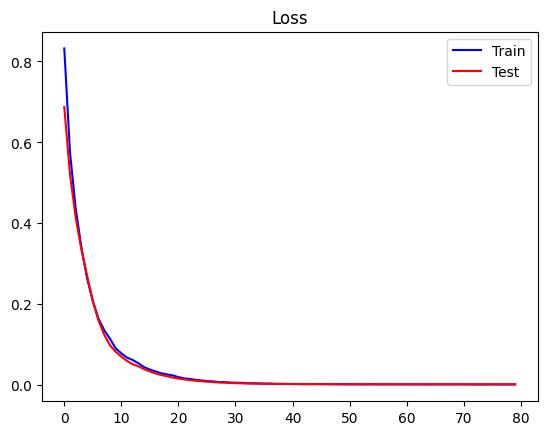

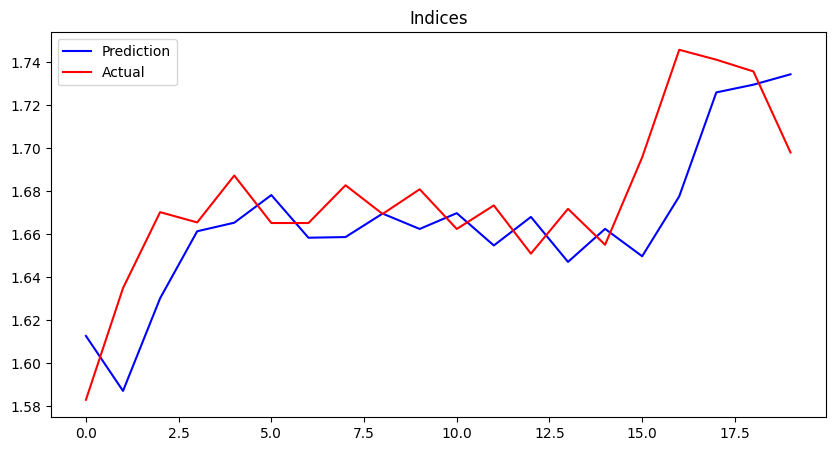

period 2017-01-01 - 2017-02-01: mae: 0.0227, mse: 0.0008


In [46]:
periods_end_before = ['2017-01-01','2017-02-01','2017-03-01',
              '2017-04-01','2017-05-01',
              '2017-06-01','2017-07-01',
              '2017-08-01','2017-09-01',
               '2017-10-01','2017-11-01',
               '2017-12-01']

results = []
device = torch.device("cpu")
collected_results = []

for i,d in enumerate(periods_end_before[1:]):
    cutoff = periods_end_before[i]
    data1 = data[data.Date<d]

    train_dataset, eval_dataset, test_dataset, x_scaler, y_scale = generate_Datasets(data1, feature_cols, target_col, cutoff, lookback=5) 

    model = SP_Model(train_dataset.X.shape[-1], hidden_dim=24, lstm_layers = 1 )
    hista = train_model(model=model,
                  train_dataset=train_dataset,
                  test_dataset=eval_dataset,
                  device=device,
                  lr=0.001,
                  epochs=80,
                  batch_size=128)

    plot_history(hista)
    mae, mse = test(model, test_dataset)
    result_str ="period {0} - {1}: mae: {2:.4f}, mse: {3:.4f}".format(cutoff, d, mae, mse)
    print("period {0} - {1}: mae: {2:.4f}, mse: {3:.4f}".format(cutoff, d, mae, mse))
    collected_results.append(result_str)
    break
    

    

In [35]:
def test2(model, test_dataset, y_scaler, batch_size=100):
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    model.eval()
    preds = []
    ys = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            outputs = model(x).view(-1)
            preds.append(outputs.cpu().numpy())
            ys.append(y.view(-1).numpy())

    preds = np.concatenate(preds)
    ys = np.concatenate(ys)

    mae = np.abs(preds - ys).mean()
    mse = np.square(preds - ys).mean()

    # 逆放缩
    preds_original = y_scaler.inverse_transform(preds.reshape(-1, 1))
    ys_original = y_scaler.inverse_transform(ys.reshape(-1, 1))

    # 绘制原始与预测的股票价格
    plt.figure(figsize=(10,5))
    plt.plot(ys_original, label='Actual', color='red')
    plt.plot(preds_original, label='Predicted', color='blue')
    plt.title('Actual vs Predicted Stock Price')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return mae, mse


Training Start
Epoch:1 / 80, train mse:0.6721 train_mae:0.7442, valid mse:0.5474 valid mae:0.6819
Epoch:2 / 80, train mse:0.4481 train_mae:0.6098, valid mse:0.4030 valid mae:0.5843
Epoch:3 / 80, train mse:0.3321 train_mae:0.5216, valid mse:0.3132 valid mae:0.5108
Epoch:4 / 80, train mse:0.2529 train_mae:0.4505, valid mse:0.2465 valid mae:0.4499
Epoch:5 / 80, train mse:0.1969 train_mae:0.3954, valid mse:0.1972 valid mae:0.3998
Epoch:6 / 80, train mse:0.1520 train_mae:0.3440, valid mse:0.1593 valid mae:0.3571
Epoch:7 / 80, train mse:0.1204 train_mae:0.3028, valid mse:0.1240 valid mae:0.3130
Epoch:8 / 80, train mse:0.0988 train_mae:0.2720, valid mse:0.0906 valid mae:0.2658
Epoch:9 / 80, train mse:0.0771 train_mae:0.2379, valid mse:0.0726 valid mae:0.2337
Epoch:10 / 80, train mse:0.0630 train_mae:0.2134, valid mse:0.0583 valid mae:0.2090
Epoch:11 / 80, train mse:0.0530 train_mae:0.1947, valid mse:0.0506 valid mae:0.1890
Epoch:12 / 80, train mse:0.0448 train_mae:0.1764, valid mse:0.0397 val

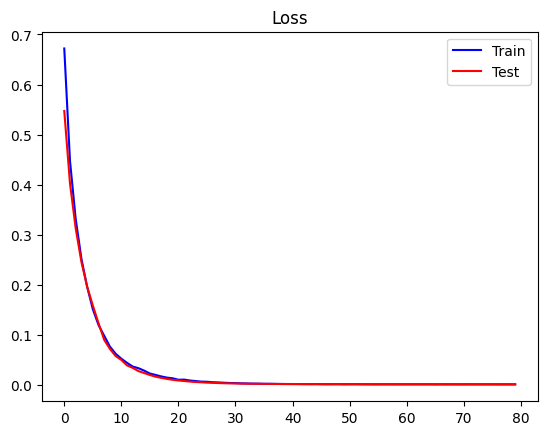

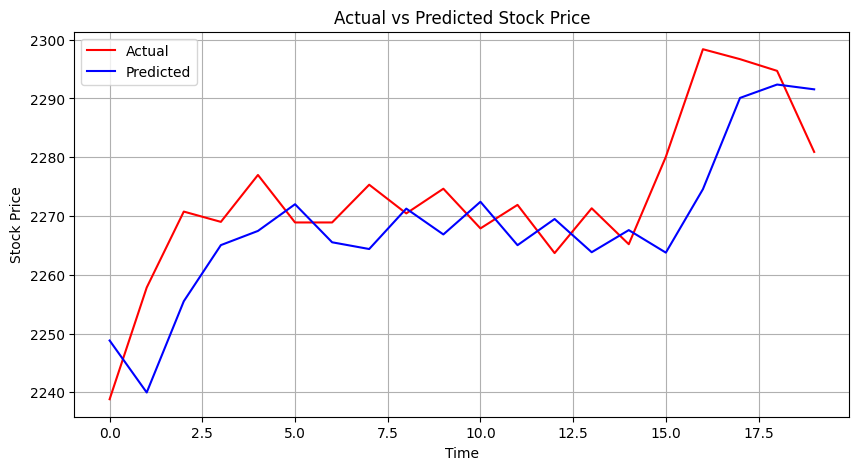

period 2017-01-01 - 2017-02-01: mae: 0.0232, mse: 0.0008
Training Start
Epoch:1 / 80, train mse:0.5785 train_mae:0.6890, valid mse:0.4483 valid mae:0.6096
Epoch:2 / 80, train mse:0.3628 train_mae:0.5453, valid mse:0.3207 valid mae:0.5159
Epoch:3 / 80, train mse:0.2559 train_mae:0.4556, valid mse:0.2430 valid mae:0.4470
Epoch:4 / 80, train mse:0.1920 train_mae:0.3909, valid mse:0.1907 valid mae:0.3918
Epoch:5 / 80, train mse:0.1449 train_mae:0.3364, valid mse:0.1525 valid mae:0.3464
Epoch:6 / 80, train mse:0.1122 train_mae:0.2927, valid mse:0.1220 valid mae:0.3075
Epoch:7 / 80, train mse:0.0895 train_mae:0.2586, valid mse:0.0933 valid mae:0.2694
Epoch:8 / 80, train mse:0.0721 train_mae:0.2306, valid mse:0.0717 valid mae:0.2342
Epoch:9 / 80, train mse:0.0578 train_mae:0.2053, valid mse:0.0572 valid mae:0.2052
Epoch:10 / 80, train mse:0.0466 train_mae:0.1838, valid mse:0.0461 valid mae:0.1832
Epoch:11 / 80, train mse:0.0397 train_mae:0.1685, valid mse:0.0378 valid mae:0.1637
Epoch:12 / 80

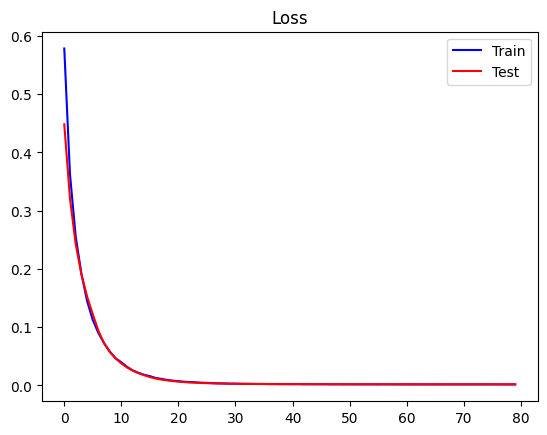

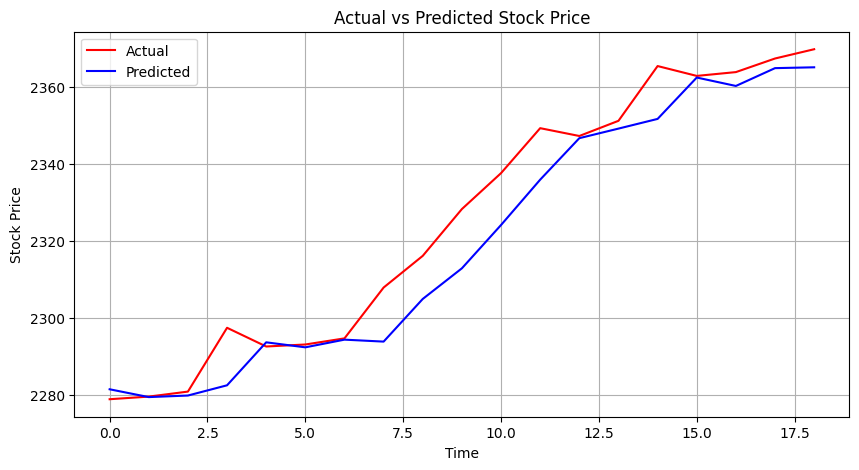

period 2017-02-01 - 2017-03-01: mae: 0.0165, mse: 0.0005
Training Start
Epoch:1 / 80, train mse:0.7603 train_mae:0.7895, valid mse:0.6174 valid mae:0.7173
Epoch:2 / 80, train mse:0.5020 train_mae:0.6452, valid mse:0.4615 valid mae:0.6189
Epoch:3 / 80, train mse:0.3735 train_mae:0.5521, valid mse:0.3609 valid mae:0.5441
Epoch:4 / 80, train mse:0.2843 train_mae:0.4762, valid mse:0.2942 valid mae:0.4863
Epoch:5 / 80, train mse:0.2224 train_mae:0.4162, valid mse:0.2448 valid mae:0.4401
Epoch:6 / 80, train mse:0.1821 train_mae:0.3710, valid mse:0.1965 valid mae:0.3929
Epoch:7 / 80, train mse:0.1497 train_mae:0.3353, valid mse:0.1491 valid mae:0.3442
Epoch:8 / 80, train mse:0.1223 train_mae:0.3008, valid mse:0.1189 valid mae:0.3047
Epoch:9 / 80, train mse:0.0997 train_mae:0.2700, valid mse:0.0973 valid mae:0.2741
Epoch:10 / 80, train mse:0.0852 train_mae:0.2471, valid mse:0.0806 valid mae:0.2464
Epoch:11 / 80, train mse:0.0709 train_mae:0.2249, valid mse:0.0672 valid mae:0.2243
Epoch:12 / 80

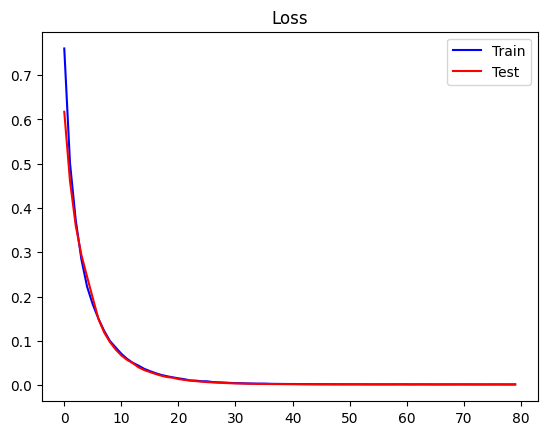

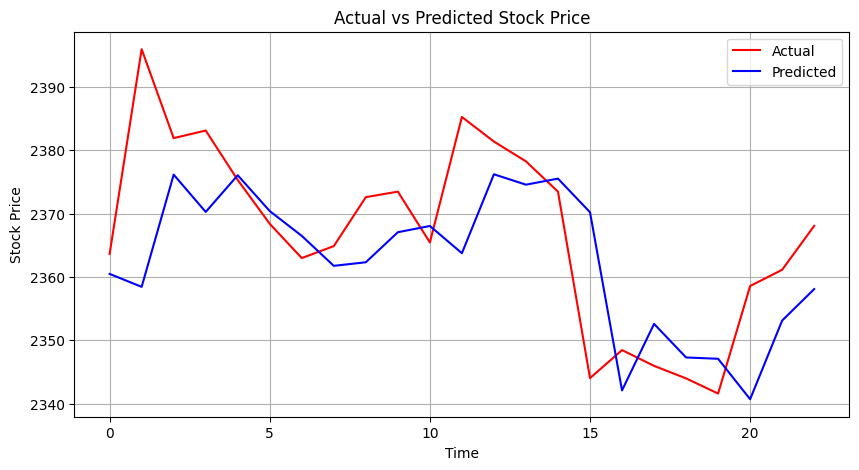

period 2017-03-01 - 2017-04-01: mae: 0.0238, mse: 0.0011
Training Start
Epoch:1 / 80, train mse:0.9614 train_mae:0.8716, valid mse:0.8384 valid mae:0.8276
Epoch:2 / 80, train mse:0.6476 train_mae:0.7321, valid mse:0.6395 valid mae:0.7209
Epoch:3 / 80, train mse:0.4962 train_mae:0.6349, valid mse:0.5398 valid mae:0.6523
Epoch:4 / 80, train mse:0.4045 train_mae:0.5700, valid mse:0.4659 valid mae:0.5960
Epoch:5 / 80, train mse:0.3177 train_mae:0.4996, valid mse:0.3707 valid mae:0.5327
Epoch:6 / 80, train mse:0.2581 train_mae:0.4488, valid mse:0.2581 valid mae:0.4430
Epoch:7 / 80, train mse:0.2071 train_mae:0.3958, valid mse:0.2152 valid mae:0.4040
Epoch:8 / 80, train mse:0.1758 train_mae:0.3606, valid mse:0.1781 valid mae:0.3658
Epoch:9 / 80, train mse:0.1406 train_mae:0.3237, valid mse:0.1493 valid mae:0.3289
Epoch:10 / 80, train mse:0.1297 train_mae:0.3055, valid mse:0.1260 valid mae:0.3029
Epoch:11 / 80, train mse:0.1164 train_mae:0.2892, valid mse:0.1074 valid mae:0.2772
Epoch:12 / 80

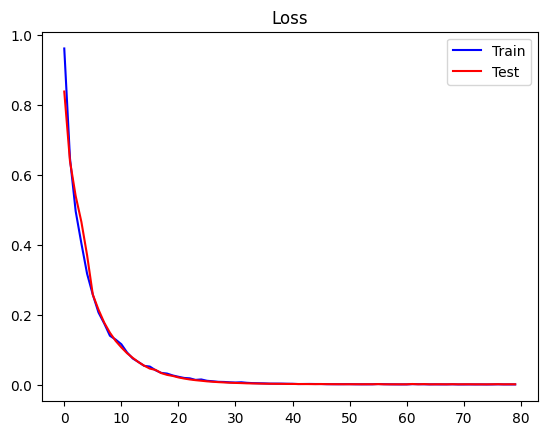

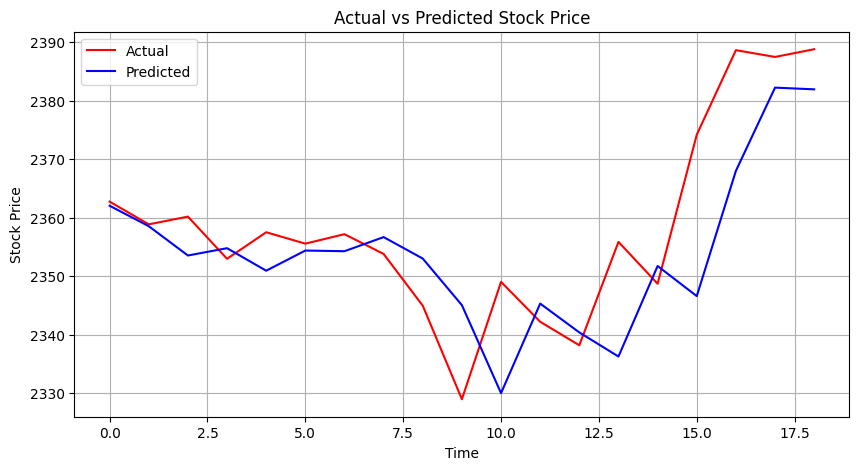

period 2017-04-01 - 2017-05-01: mae: 0.0214, mse: 0.0009
Training Start
Epoch:1 / 80, train mse:0.3981 train_mae:0.5646, valid mse:0.2838 valid mae:0.4828
Epoch:2 / 80, train mse:0.2189 train_mae:0.4193, valid mse:0.1882 valid mae:0.3900
Epoch:3 / 80, train mse:0.1457 train_mae:0.3402, valid mse:0.1329 valid mae:0.3230
Epoch:4 / 80, train mse:0.0995 train_mae:0.2760, valid mse:0.1046 valid mae:0.2831
Epoch:5 / 80, train mse:0.0727 train_mae:0.2327, valid mse:0.0738 valid mae:0.2380
Epoch:6 / 80, train mse:0.0528 train_mae:0.1962, valid mse:0.0532 valid mae:0.2000
Epoch:7 / 80, train mse:0.0415 train_mae:0.1742, valid mse:0.0384 valid mae:0.1671
Epoch:8 / 80, train mse:0.0294 train_mae:0.1430, valid mse:0.0292 valid mae:0.1453
Epoch:9 / 80, train mse:0.0237 train_mae:0.1286, valid mse:0.0228 valid mae:0.1271
Epoch:10 / 80, train mse:0.0200 train_mae:0.1178, valid mse:0.0174 valid mae:0.1099
Epoch:11 / 80, train mse:0.0149 train_mae:0.1008, valid mse:0.0141 valid mae:0.0969
Epoch:12 / 80

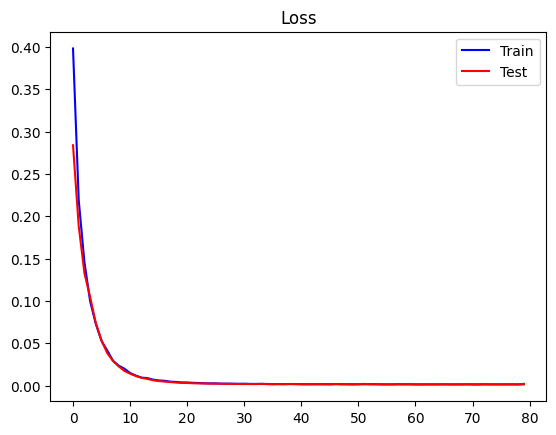

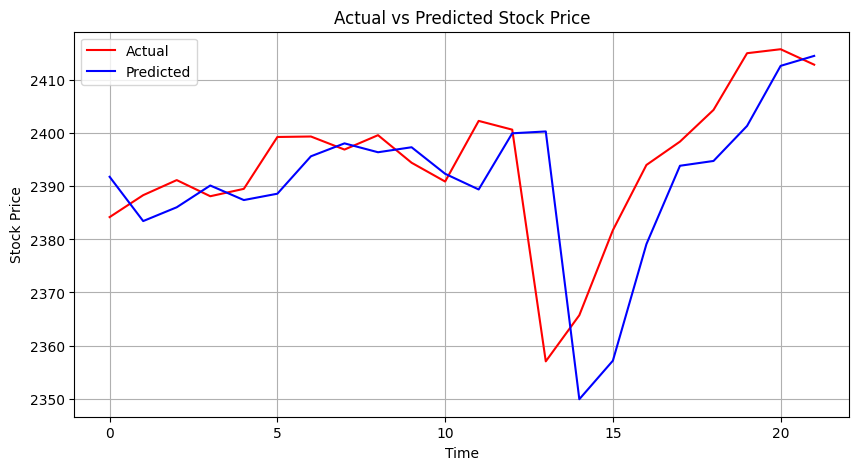

period 2017-05-01 - 2017-06-01: mae: 0.0225, mse: 0.0011
Training Start
Epoch:1 / 80, train mse:0.7582 train_mae:0.7856, valid mse:0.6157 valid mae:0.7124
Epoch:2 / 80, train mse:0.5009 train_mae:0.6407, valid mse:0.4611 valid mae:0.6137
Epoch:3 / 80, train mse:0.3731 train_mae:0.5520, valid mse:0.3686 valid mae:0.5423
Epoch:4 / 80, train mse:0.2775 train_mae:0.4685, valid mse:0.2826 valid mae:0.4710
Epoch:5 / 80, train mse:0.2096 train_mae:0.4008, valid mse:0.2222 valid mae:0.4146
Epoch:6 / 80, train mse:0.1682 train_mae:0.3549, valid mse:0.1750 valid mae:0.3657
Epoch:7 / 80, train mse:0.1391 train_mae:0.3201, valid mse:0.1301 valid mae:0.3119
Epoch:8 / 80, train mse:0.1140 train_mae:0.2883, valid mse:0.1032 valid mae:0.2759
Epoch:9 / 80, train mse:0.0923 train_mae:0.2569, valid mse:0.0835 valid mae:0.2476
Epoch:10 / 80, train mse:0.0756 train_mae:0.2297, valid mse:0.0687 valid mae:0.2226
Epoch:11 / 80, train mse:0.0628 train_mae:0.2093, valid mse:0.0571 valid mae:0.2032
Epoch:12 / 80

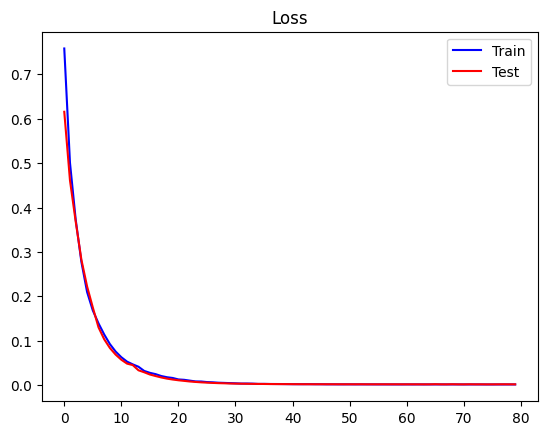

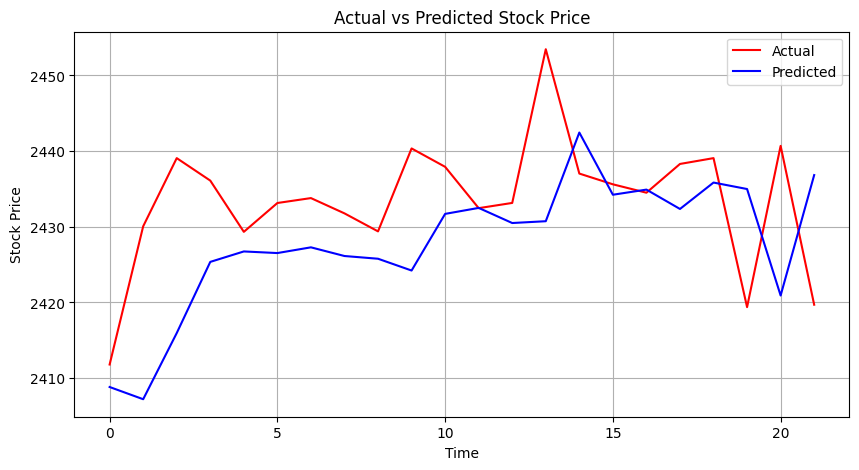

period 2017-06-01 - 2017-07-01: mae: 0.0235, mse: 0.0009
Training Start
Epoch:1 / 80, train mse:0.3424 train_mae:0.5101, valid mse:0.2382 valid mae:0.4283
Epoch:2 / 80, train mse:0.1719 train_mae:0.3708, valid mse:0.1611 valid mae:0.3454
Epoch:3 / 80, train mse:0.1091 train_mae:0.2925, valid mse:0.1135 valid mae:0.2871
Epoch:4 / 80, train mse:0.0745 train_mae:0.2386, valid mse:0.0810 valid mae:0.2401
Epoch:5 / 80, train mse:0.0517 train_mae:0.1955, valid mse:0.0559 valid mae:0.1985
Epoch:6 / 80, train mse:0.0369 train_mae:0.1639, valid mse:0.0372 valid mae:0.1619
Epoch:7 / 80, train mse:0.0278 train_mae:0.1405, valid mse:0.0250 valid mae:0.1313
Epoch:8 / 80, train mse:0.0208 train_mae:0.1192, valid mse:0.0181 valid mae:0.1124
Epoch:9 / 80, train mse:0.0159 train_mae:0.1033, valid mse:0.0145 valid mae:0.0990
Epoch:10 / 80, train mse:0.0133 train_mae:0.0934, valid mse:0.0106 valid mae:0.0826
Epoch:11 / 80, train mse:0.0105 train_mae:0.0828, valid mse:0.0087 valid mae:0.0731
Epoch:12 / 80

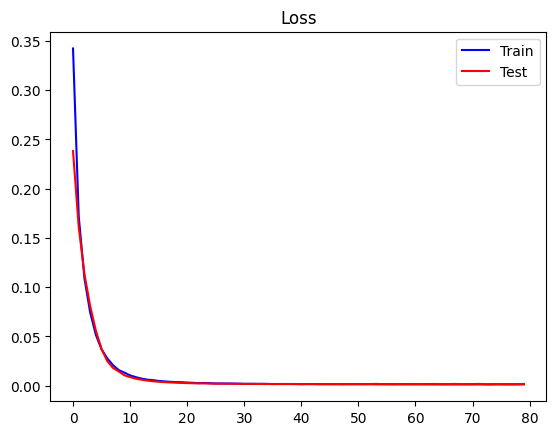

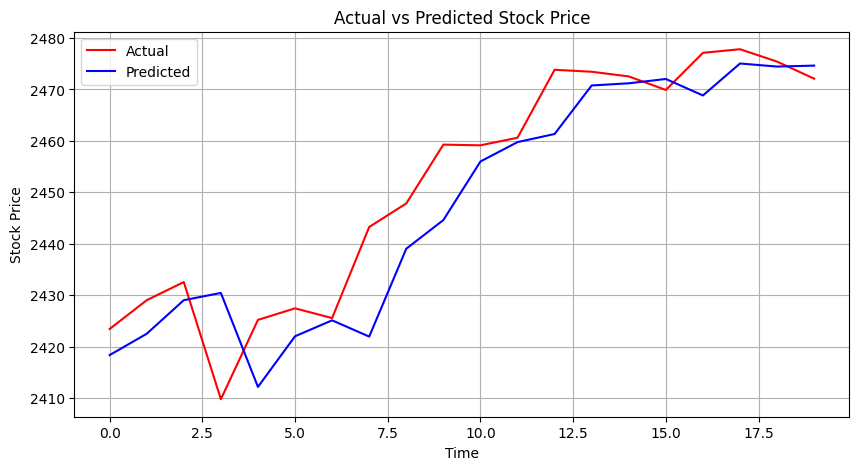

period 2017-07-01 - 2017-08-01: mae: 0.0173, mse: 0.0006
Training Start
Epoch:1 / 80, train mse:0.4465 train_mae:0.5945, valid mse:0.3505 valid mae:0.5358
Epoch:2 / 80, train mse:0.2624 train_mae:0.4590, valid mse:0.2342 valid mae:0.4363
Epoch:3 / 80, train mse:0.1780 train_mae:0.3754, valid mse:0.1698 valid mae:0.3681
Epoch:4 / 80, train mse:0.1252 train_mae:0.3121, valid mse:0.1297 valid mae:0.3181
Epoch:5 / 80, train mse:0.0909 train_mae:0.2613, valid mse:0.0950 valid mae:0.2697
Epoch:6 / 80, train mse:0.0676 train_mae:0.2232, valid mse:0.0680 valid mae:0.2271
Epoch:7 / 80, train mse:0.0533 train_mae:0.1960, valid mse:0.0507 valid mae:0.1953
Epoch:8 / 80, train mse:0.0399 train_mae:0.1682, valid mse:0.0382 valid mae:0.1690
Epoch:9 / 80, train mse:0.0325 train_mae:0.1520, valid mse:0.0298 valid mae:0.1482
Epoch:10 / 80, train mse:0.0260 train_mae:0.1332, valid mse:0.0233 valid mae:0.1294
Epoch:11 / 80, train mse:0.0203 train_mae:0.1181, valid mse:0.0192 valid mae:0.1176
Epoch:12 / 80

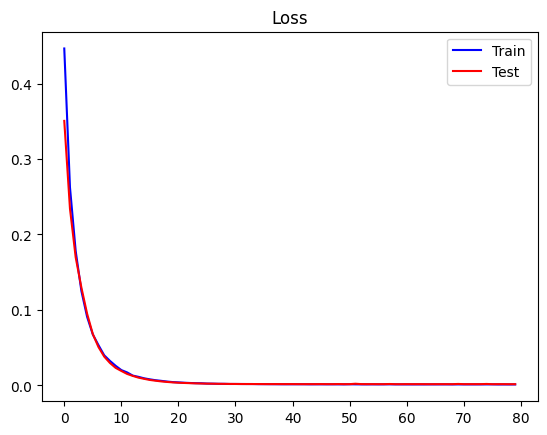

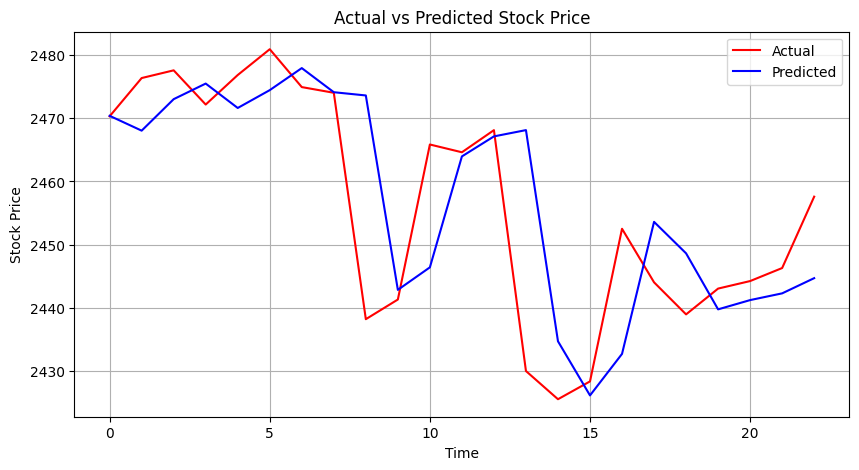

period 2017-08-01 - 2017-09-01: mae: 0.0218, mse: 0.0011
Training Start
Epoch:1 / 80, train mse:1.0001 train_mae:0.8872, valid mse:0.8228 valid mae:0.8038
Epoch:2 / 80, train mse:0.6646 train_mae:0.7329, valid mse:0.6205 valid mae:0.6969
Epoch:3 / 80, train mse:0.5016 train_mae:0.6336, valid mse:0.4870 valid mae:0.6149
Epoch:4 / 80, train mse:0.3923 train_mae:0.5545, valid mse:0.3873 valid mae:0.5451
Epoch:5 / 80, train mse:0.3099 train_mae:0.4859, valid mse:0.3273 valid mae:0.4973
Epoch:6 / 80, train mse:0.2478 train_mae:0.4287, valid mse:0.2477 valid mae:0.4274
Epoch:7 / 80, train mse:0.2083 train_mae:0.3895, valid mse:0.1989 valid mae:0.3842
Epoch:8 / 80, train mse:0.1704 train_mae:0.3500, valid mse:0.1604 valid mae:0.3431
Epoch:9 / 80, train mse:0.1389 train_mae:0.3129, valid mse:0.1362 valid mae:0.3121
Epoch:10 / 80, train mse:0.1211 train_mae:0.2903, valid mse:0.1135 valid mae:0.2852
Epoch:11 / 80, train mse:0.1037 train_mae:0.2667, valid mse:0.0957 valid mae:0.2604
Epoch:12 / 80

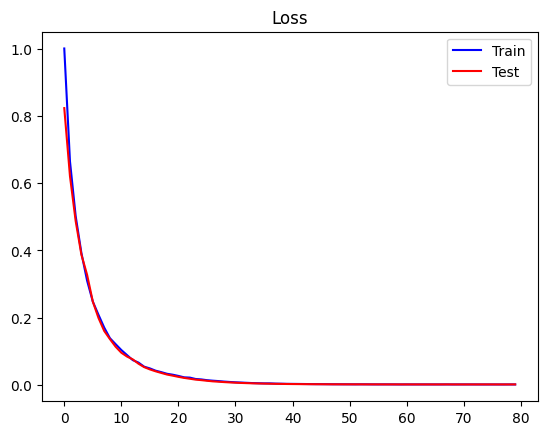

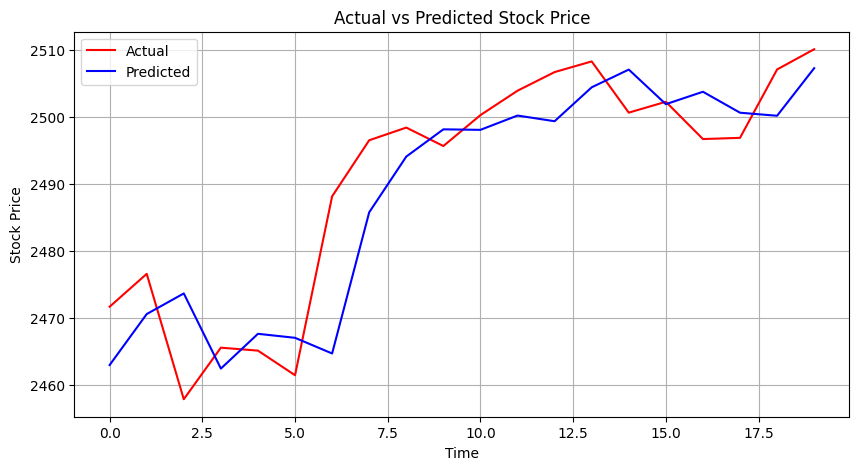

period 2017-09-01 - 2017-10-01: mae: 0.0157, mse: 0.0004
Training Start
Epoch:1 / 80, train mse:1.0271 train_mae:0.9103, valid mse:0.8147 valid mae:0.8084
Epoch:2 / 80, train mse:0.7004 train_mae:0.7519, valid mse:0.6138 valid mae:0.6979
Epoch:3 / 80, train mse:0.5229 train_mae:0.6432, valid mse:0.4854 valid mae:0.6160
Epoch:4 / 80, train mse:0.4019 train_mae:0.5520, valid mse:0.4105 valid mae:0.5607
Epoch:5 / 80, train mse:0.3181 train_mae:0.4836, valid mse:0.3324 valid mae:0.4981
Epoch:6 / 80, train mse:0.2614 train_mae:0.4360, valid mse:0.2638 valid mae:0.4391
Epoch:7 / 80, train mse:0.2181 train_mae:0.3939, valid mse:0.2129 valid mae:0.3899
Epoch:8 / 80, train mse:0.1883 train_mae:0.3637, valid mse:0.1762 valid mae:0.3544
Epoch:9 / 80, train mse:0.1493 train_mae:0.3210, valid mse:0.1503 valid mae:0.3221
Epoch:10 / 80, train mse:0.1288 train_mae:0.2951, valid mse:0.1326 valid mae:0.2989
Epoch:11 / 80, train mse:0.1158 train_mae:0.2796, valid mse:0.1247 valid mae:0.2886
Epoch:12 / 80

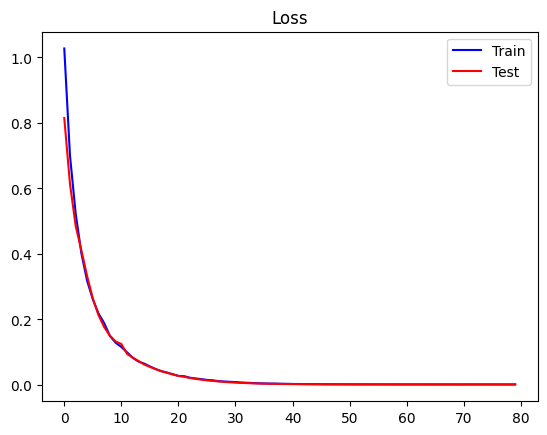

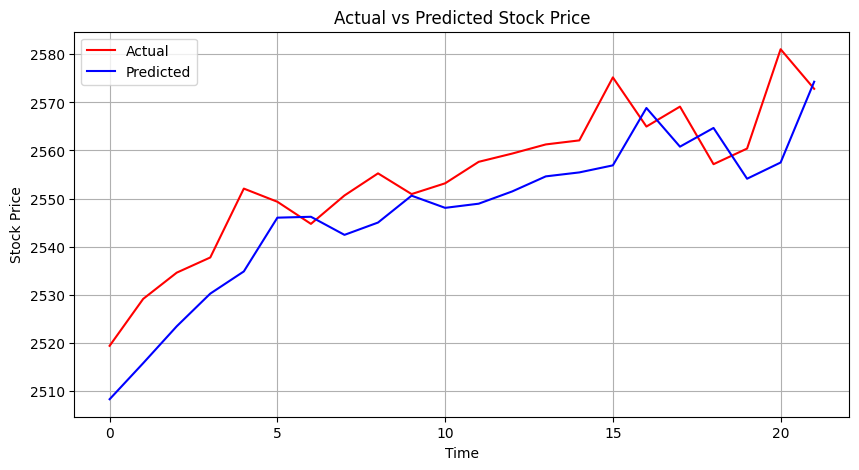

period 2017-10-01 - 2017-11-01: mae: 0.0208, mse: 0.0006
Training Start
Epoch:1 / 80, train mse:0.7372 train_mae:0.7663, valid mse:0.5967 valid mae:0.6875
Epoch:2 / 80, train mse:0.4731 train_mae:0.6149, valid mse:0.4162 valid mae:0.5720
Epoch:3 / 80, train mse:0.3367 train_mae:0.5119, valid mse:0.3278 valid mae:0.5025
Epoch:4 / 80, train mse:0.2499 train_mae:0.4323, valid mse:0.2690 valid mae:0.4482
Epoch:5 / 80, train mse:0.1947 train_mae:0.3763, valid mse:0.2105 valid mae:0.3937
Epoch:6 / 80, train mse:0.1571 train_mae:0.3350, valid mse:0.1504 valid mae:0.3306
Epoch:7 / 80, train mse:0.1262 train_mae:0.2962, valid mse:0.1139 valid mae:0.2865
Epoch:8 / 80, train mse:0.1044 train_mae:0.2682, valid mse:0.0921 valid mae:0.2572
Epoch:9 / 80, train mse:0.0883 train_mae:0.2461, valid mse:0.0762 valid mae:0.2303
Epoch:10 / 80, train mse:0.0730 train_mae:0.2243, valid mse:0.0634 valid mae:0.2112
Epoch:11 / 80, train mse:0.0619 train_mae:0.2056, valid mse:0.0533 valid mae:0.1926
Epoch:12 / 80

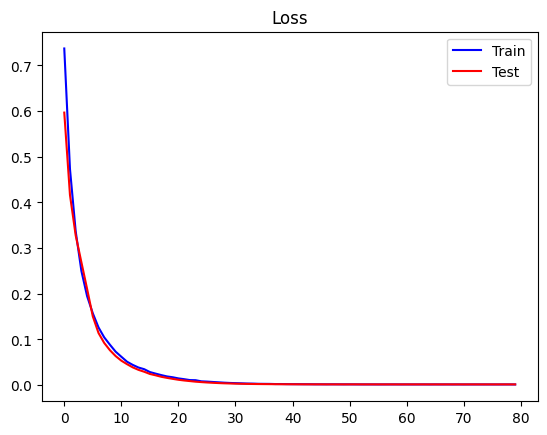

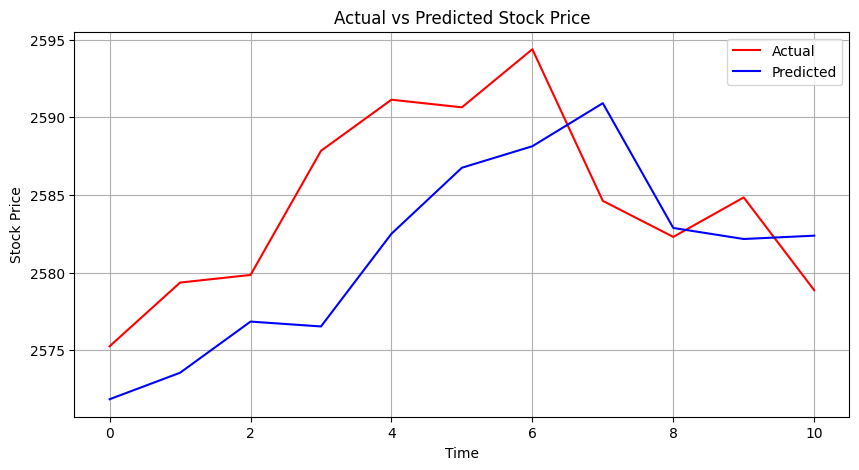

period 2017-11-01 - 2017-12-01: mae: 0.0120, mse: 0.0002


In [44]:
periods_end_before = ['2017-01-01','2017-02-01','2017-03-01',
              '2017-04-01','2017-05-01',
              '2017-06-01','2017-07-01',
              '2017-08-01','2017-09-01',
               '2017-10-01','2017-11-01',
               '2017-12-01']

results = []
device = torch.device("cpu")
collected_results2 = []

for i,d in enumerate(periods_end_before[1:]):
    cutoff = periods_end_before[i]
    data1 = data[data.Date<d]

    train_dataset, eval_dataset, test_dataset, x_scaler, y_scale = generate_Datasets(data1, feature_cols, target_col, cutoff, lookback=5) 

    model = SP_Model(train_dataset.X.shape[-1], hidden_dim=24, lstm_layers = 1 )
    hista = train_model(model=model,
                  train_dataset=train_dataset,
                  test_dataset=eval_dataset,
                  device=device,
                  lr=0.001,
                  epochs=80,
                  batch_size=128)

    plot_history(hista)
    mae, mse = test2(model, test_dataset, y_scale)
    result_str ="period {0} - {1}: mae: {2:.4f}, mse: {3:.4f}".format(cutoff, d, mae, mse)
    collected_results2.append(result_str)
    print("period {0} - {1}: mae: {2:.4f}, mse: {3:.4f}".format(cutoff, d, mae, mse))
    

In [45]:
print('Deep Learning prediction accuracy')
for result in collected_results2:
    print(result)

Deep Learning prediction accuracy
period 2017-01-01 - 2017-02-01: mae: 0.0232, mse: 0.0008
period 2017-02-01 - 2017-03-01: mae: 0.0165, mse: 0.0005
period 2017-03-01 - 2017-04-01: mae: 0.0238, mse: 0.0011
period 2017-04-01 - 2017-05-01: mae: 0.0214, mse: 0.0009
period 2017-05-01 - 2017-06-01: mae: 0.0225, mse: 0.0011
period 2017-06-01 - 2017-07-01: mae: 0.0235, mse: 0.0009
period 2017-07-01 - 2017-08-01: mae: 0.0173, mse: 0.0006
period 2017-08-01 - 2017-09-01: mae: 0.0218, mse: 0.0011
period 2017-09-01 - 2017-10-01: mae: 0.0157, mse: 0.0004
period 2017-10-01 - 2017-11-01: mae: 0.0208, mse: 0.0006
period 2017-11-01 - 2017-12-01: mae: 0.0120, mse: 0.0002
